# Import libraries

In [ ]:
import requests

from bs4 import BeautifulSoup

import time

import pandas as pd
import numpy as np

import re
from nltk.corpus import stopwords

from textblob import Word
from textblob import TextBlob

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer


# Scraping Tesla customers reviews for 2024 from Trustpilot.com

In [ ]:
url = 'https://www.trustpilot.com/review/www.teslamotors.com?date=last12months' # page 1

r = requests.get(url)

soup = BeautifulSoup(r.text, 'html.parser')

results = soup.findAll(class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')

reviews = []
reviews.append(results)

time.sleep(10 * 60) #10 minuates

# traversing through the remaining pages and scraping customer reviews
# traverse through evry page 1 at a time and scrape reviews if it doesnt work
for i in range(2,6):
     url = f'https://www.trustpilot.com/review/www.teslamotors.com?date=last12months&page={i}'

     r = requests.get(url)

     soup = BeautifulSoup(r.text, 'html.parser')

     results = soup.findAll(class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn')

     reviews.append(results)

     time.sleep(10 * 60) #10 minuates

In [ ]:
print(r.status_code)

200


In [ ]:
reviews

[[<p class="typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn" data-service-review-text-typography="true">Same atrocious customer service again and again. Keep cancelling mobile service appointments after making us wait the whole time. There is no way to lodge a complaint, nothing on website, no postal address, no email address, chat is not answered, some manager has to call you back whenever for you to be able to complaint. They do not seem to subscribe to any regulator like Motoring Ombudsman. If they don't allow complaints, cannot escalate the complaint to regulator anyway. This is effectively an unregulated business, which is scandalous. Not sure how they are allowed to exist in the UK or any so called developed country. Completely based on loopholes and I am sure illegal somewhere. Too late if you have already purchased TESLA, beware the others, this is real. Something like a mass legal action is necessary. You don't get to be be the world

In [ ]:
reviews = [result.text for result in results]

In [ ]:
reviews

["Same atrocious customer service again and again. Keep cancelling mobile service appointments after making us wait the whole time. There is no way to lodge a complaint, nothing on website, no postal address, no email address, chat is not answered, some manager has to call you back whenever for you to be able to complaint. They do not seem to subscribe to any regulator like Motoring Ombudsman. If they don't allow complaints, cannot escalate the complaint to regulator anyway. This is effectively an unregulated business, which is scandalous. Not sure how they are allowed to exist in the UK or any so called developed country. Completely based on loopholes and I am sure illegal somewhere. Too late if you have already purchased TESLA, beware the others, this is real. Something like a mass legal action is necessary. You don't get to be be the world's richest by simply obeying the law.",
 "Warning - Tesla Legal Scam. Read this before you take Tesla to court. Tesla has two companies. One is ca

In [ ]:
df = pd.DataFrame(np.array(reviews), columns=['review'])

In [ ]:
df.head()

,review
0,Same atrocious customer service again and agai...
1,Warning - Tesla Legal Scam. Read this before y...
2,Car is pretty good but the infotainment system...
3,"The 12v battery died, I arranged an appointmen..."
4,Alarm front system fault part of a recall re a...


In [ ]:
df.shape

(12, 1)

In [ ]:
# export to csv
df.to_csv('Telsa Reviews 2024.csv')

In [ ]:
df = pd.read_csv(r"/Telsa Reviews 2024.csv")

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,review
0,0,0,Still waiting to hear from customer service s....
1,1,1,"One of the worst car is Tesla, very expensive ..."
2,2,2,I can't understand the fixation that few have ...
3,3,3,"Great car, but the customer service side is sh..."
4,4,4,"I bought a Tesla car 3 Months ago,Unfortunatel..."


In [ ]:
df.shape

(329, 3)

In [ ]:
df.dtypes

Unnamed: 0.1     int64
Unnamed: 0       int64
review          object
dtype: object

In [ ]:
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

In [ ]:
df.head()

,review
0,Still waiting to hear from customer service s....
1,"One of the worst car is Tesla, very expensive ..."
2,I can't understand the fixation that few have ...
3,"Great car, but the customer service side is sh..."
4,"I bought a Tesla car 3 Months ago,Unfortunatel..."


# Data prep

In [ ]:
df2 = df.copy()

In [ ]:
def clean_post(post):
    # Remove URLs
    post = re.sub(r'http\S+|www\S+|https\S+', '', post, flags=re.MULTILINE)

    # Remove punctuation
    post = re.sub(r'[^\w\s]', '', post)

    # Remove extra spaces
    post = re.sub(r'\s+', ' ', post).strip()

    # Convert to lowercase
    post = post.lower()

    return post


df2['cleaned_reviews'] = df2['review'].apply(lambda x: clean_post(x))

In [ ]:
df2.head()

,review,cleaned_reviews
0,Still waiting to hear from customer service s....,still waiting to hear from customer service s ...
1,"One of the worst car is Tesla, very expensive ...",one of the worst car is tesla very expensive a...
2,I can't understand the fixation that few have ...,i cant understand the fixation that few have a...
3,"Great car, but the customer service side is sh...",great car but the customer service side is sho...
4,"I bought a Tesla car 3 Months ago,Unfortunatel...",i bought a tesla car 3 months agounfortunately...


In [ ]:
stop_words = stopwords.words('english')

# Remove Stopwords
df2['cleaned_reviews'] = df2['cleaned_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [ ]:
df2.head()

,review,cleaned_reviews
0,Still waiting to hear from customer service s....,still waiting hear customer service issues rai...
1,"One of the worst car is Tesla, very expensive ...",one worst car tesla expensive designed rubbish...
2,I can't understand the fixation that few have ...,cant understand fixation tesla aesthetics feat...
3,"Great car, but the customer service side is sh...",great car customer service side shockingi serv...
4,"I bought a Tesla car 3 Months ago,Unfortunatel...",bought tesla car 3 months agounfortunately one...


In [ ]:
# Lemmatize review
df2['lemms'] = df2['cleaned_reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
df2.head()

,review,cleaned_reviews,lemms
0,Still waiting to hear from customer service s....,still waiting hear customer service issues rai...,still waiting hear customer service issue rais...
1,"One of the worst car is Tesla, very expensive ...",one worst car tesla expensive designed rubbish...,one worst car tesla expensive designed rubbish...
2,I can't understand the fixation that few have ...,cant understand fixation tesla aesthetics feat...,cant understand fixation tesla aesthetic featu...
3,"Great car, but the customer service side is sh...",great car customer service side shockingi serv...,great car customer service side shockingi serv...
4,"I bought a Tesla car 3 Months ago,Unfortunatel...",bought tesla car 3 months agounfortunately one...,bought tesla car 3 month agounfortunately one ...


# Polarity - the degree to which the text analysed is positive or negative between a range of -1 to 1.

The polarity metric refers to the degree to which the text analysed is positive or negative, between a range of -1 to 1.

A score of 1 means highly positive whereas -1 is considered well and truly negative.

In [ ]:
df2['polarity'] = df2['lemms'].apply(lambda x: TextBlob(x).sentiment[0])

In [ ]:
df2.head()

,review,cleaned_reviews,lemms,polarity
0,Still waiting to hear from customer service s....,still waiting hear customer service issues rai...,still waiting hear customer service issue rais...,0.000000
1,"One of the worst car is Tesla, very expensive ...",one worst car tesla expensive designed rubbish...,one worst car tesla expensive designed rubbish...,0.171429
2,I can't understand the fixation that few have ...,cant understand fixation tesla aesthetics feat...,cant understand fixation tesla aesthetic featu...,0.211111
3,"Great car, but the customer service side is sh...",great car customer service side shockingi serv...,great car customer service side shockingi serv...,0.250000
4,"I bought a Tesla car 3 Months ago,Unfortunatel...",bought tesla car 3 months agounfortunately one...,bought tesla car 3 month agounfortunately one ...,-0.500000


# Subjectivity - the degree to which the text analysed relates to personal emotion or factual information between a scale of 0 to 1.

Subjectivity is the degree to which the text analysed relates to personal emotion or factual information between a scale of 0 to 1.

With scores closer to 1 indicating a higher level of subjectivity and being based mostly on opinion.a

In [ ]:
# Calculate subjectivity
df2['subjectivity'] = df2['lemms'].apply(lambda x: TextBlob(x).sentiment[1])

In [ ]:
df2.head()

,review,cleaned_reviews,lemms,polarity,subjectivity
0,Still waiting to hear from customer service s....,still waiting hear customer service issues rai...,still waiting hear customer service issue rais...,0.000000,0.000000
1,"One of the worst car is Tesla, very expensive ...",one worst car tesla expensive designed rubbish...,one worst car tesla expensive designed rubbish...,0.171429,0.846429
2,I can't understand the fixation that few have ...,cant understand fixation tesla aesthetics feat...,cant understand fixation tesla aesthetic featu...,0.211111,0.388889
3,"Great car, but the customer service side is sh...",great car customer service side shockingi serv...,great car customer service side shockingi serv...,0.250000,0.675000
4,"I bought a Tesla car 3 Months ago,Unfortunatel...",bought tesla car 3 months agounfortunately one...,bought tesla car 3 month agounfortunately one ...,-0.500000,0.633333


# BERT Model

In [ ]:

tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
df2['sentiment'] = df2['review'].apply(lambda x: sentiment_score(x[:512]))

In [ ]:
df2.head()

,Unnamed: 0.1,Unnamed: 0,review,sentiment
0,0,0,Still waiting to hear from customer service s....,1
1,1,1,"One of the worst car is Tesla, very expensive ...",1
2,2,2,I can't understand the fixation that few have ...,2
3,3,3,"Great car, but the customer service side is sh...",3
4,4,4,"I bought a Tesla car 3 Months ago,Unfortunatel...",1


C:\Users\Shivan\AppData\Local\Temp\ipykernel_8024\2754642307.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title = "Sentiment Score \n\n 1 to 2 : Negative sentiment \n 3        : Neutral sentiment \n 4 to 5 : Positive sentiment")


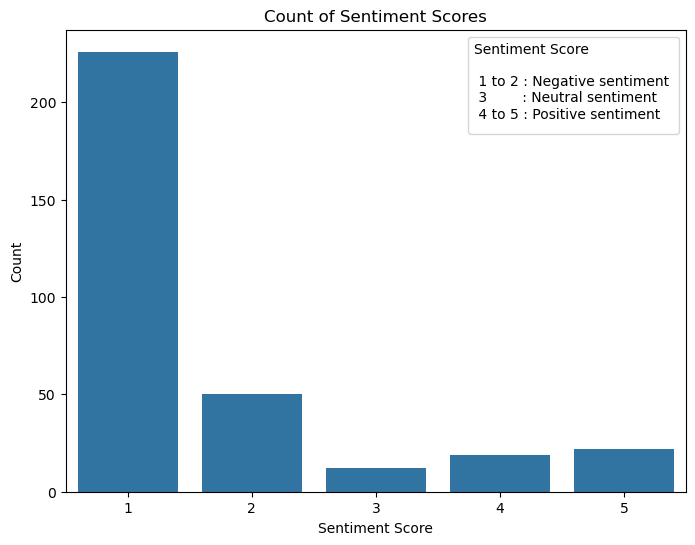

In [ ]:
# Count of sentiment scores
plt.figure(figsize=(8, 6))
sns.countplot(x = 'sentiment', data = df2)
plt.title('Count of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend(title = "Sentiment Score \n\n 1 to 2 : Negative sentiment \n 3        : Neutral sentiment \n 4 to 5 : Positive sentiment")
plt.show()



The countplot counts the frequency of all the differnt sentiment scores of Tesla review for 2024.

Sentiment score 1 appears themost followed by Sentiment score 2.
This shows that majority of the reviews are negative.

But are these negative reviews on customer experiecnes at Tesla dealerships with staff members or are they negative reviews on the Tesla cars?

# Word Frequency & Topic Modelling

In [ ]:
# Return frequency of values
freq= pd.Series(" ".join(df2['cleaned_reviews']).split()).value_counts()[:30]

In [ ]:
freq

tesla         641
car           472
service       389
customer      213
get           186
would         153
one           123
model         113
new           112
company       110
time          106
back          103
experience     99
dont           97
told           94
3              93
never          89
even           88
app            79
vehicle        73
cars           69
like           69
issues         66
still          66
2              62
buy            61
take           61
could          60
another        60
customers      59
Name: count, dtype: int64

In [ ]:
# Return frequency of lemmatized values
freq= pd.Series(" ".join(df2['lemms']).split()).value_counts()[:30]

In [ ]:
freq

tesla         692
car           541
service       406
customer      272
get           191
would         153
time          138
company       125
one           124
model         117
new           112
issue         110
day           108
experience    104
back          103
dont           97
month          95
told           94
3              93
never          89
vehicle        89
even           88
app            79
week           78
take           78
like           70
call           69
still          66
need           63
buy            62
Name: count, dtype: int64


By looking at the top 30 words with the highest frequency, i.e, the top 30 words appearing the most among reviews, we can see that "car", "service" and "customer" could mean that reviews are based on customer experiences with the service/staff member from Tesla.

We will explore this further by analyising different topics from all of the reviews

In [ ]:
vectorizer = CountVectorizer(stop_words='english', lowercase=True)

X_counts = vectorizer.fit_transform(df2['review'])

feature_names = vectorizer.get_feature_names_out()

print(f"Number of unique words: {len(feature_names)}")


Number of unique words: 4182


In [ ]:
#Initialize LDA with  10 topics
lda_model = LatentDirichletAllocation(n_components=10, random_state=1234)

lda_model.fit(X_counts)

# Get the components (topics)
topics = lda_model.components_

# Display the top words for each topic
n_top_words = 10  # Number of top words per topic

for topic_idx, topic in enumerate(topics):
    print(f"\nTopic #{topic_idx + 1}:")
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print("Top words: ", ", ".join(top_words))



Topic #1:
Top words:  tesla, car, service, customer, app, time, just, told, new, don

Topic #2:
Top words:  read, disgusting, shocking, test, 500, print, cost, insurance, accident, small

Topic #3:
Top words:  car, tesla, ve, really, customer, service, contact, deposit, went, just

Topic #4:
Top words:  tesla, car, service, customer, model, cars, company, customers, issues, care

Topic #5:
Top words:  car, tesla, new, model, apr, use, know, time, thais, experience

Topic #6:
Top words:  tesla, car, new, time, march, auto, 2024, company, make, service

Topic #7:
Top words:  tesla, service, car, customer, company, told, experience, just, finance, customers

Topic #8:
Top words:  tesla, service, experience, customer, insurance, like, new, days, model, car

Topic #9:
Top words:  tesla, customer, service, car, solar, panels, company, vehicle, time, model

Topic #10:
Top words:  tesla, service, customer, car, like, ve, safety, time, steering, months


"customer" and "service" appear very often amongst the topics.
 Hence I will perform further analysis.

# Analysis

## Method 1 - Using a BERT

In [ ]:
df2.head()

,review,cleaned_reviews,lemms
0,Still waiting to hear from customer service s....,still waiting hear customer service issues rai...,still waiting hear customer service issue rais...
1,"One of the worst car is Tesla, very expensive ...",one worst car tesla expensive designed rubbish...,one worst car tesla expensive designed rubbish...
2,I can't understand the fixation that few have ...,cant understand fixation tesla aesthetics feat...,cant understand fixation tesla aesthetic featu...
3,"Great car, but the customer service side is sh...",great car customer service side shockingi serv...,great car customer service side shockingi serv...
4,"I bought a Tesla car 3 Months ago,Unfortunatel...",bought tesla car 3 months agounfortunately one...,bought tesla car 3 month agounfortunately one ...


In [ ]:
customer_service_reviews = df2[df2['review'].str.contains(r'\bcustomer\b.*\bservice\b', case=False)]


In [ ]:
customer_service_reviews.head()

,review,cleaned_reviews,lemms
0,Still waiting to hear from customer service s....,still waiting hear customer service issues rai...,still waiting hear customer service issue rais...
3,"Great car, but the customer service side is sh...",great car customer service side shockingi serv...,great car customer service side shockingi serv...
5,First time at tesla supercharger. Non Tesla EV...,first time tesla supercharger non tesla ev was...,first time tesla supercharger non tesla ev was...
6,Owner of Tesla Model X Performance and Model 3...,owner tesla model x performance model 3 perfor...,owner tesla model x performance model 3 perfor...
7,DO NOT GET INTO A LEASE AGREEMENT - with Tesla...,get lease agreement tesla financial services g...,get lease agreement tesla financial service go...


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [ ]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
customer_service_reviews = customer_service_reviews.copy() # copying df to avoid error: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame. Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
customer_service_reviews['sentiment'] = customer_service_reviews['review'].apply(lambda x: sentiment_score(x[:512]))

In [ ]:
customer_service_reviews.head()

,review,cleaned_reviews,lemms,sentiment
0,Still waiting to hear from customer service s....,still waiting hear customer service issues rai...,still waiting hear customer service issue rais...,1
3,"Great car, but the customer service side is sh...",great car customer service side shockingi serv...,great car customer service side shockingi serv...,3
5,First time at tesla supercharger. Non Tesla EV...,first time tesla supercharger non tesla ev was...,first time tesla supercharger non tesla ev was...,1
6,Owner of Tesla Model X Performance and Model 3...,owner tesla model x performance model 3 perfor...,owner tesla model x performance model 3 perfor...,3
7,DO NOT GET INTO A LEASE AGREEMENT - with Tesla...,get lease agreement tesla financial services g...,get lease agreement tesla financial service go...,1


C:\Users\Shivan\AppData\Local\Temp\ipykernel_8580\3218570494.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title = "Sentiment Score \n\n 1 to 2 : Negative sentiment \n 3        : Neutral sentiment \n 4 to 5 : Positive sentiment")


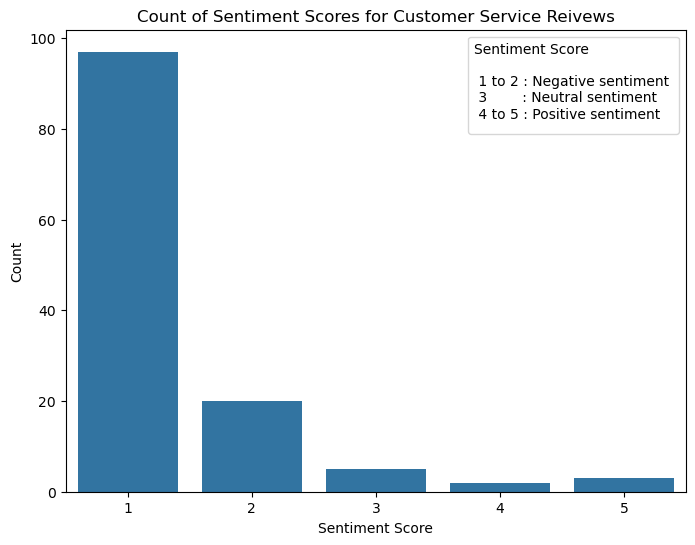

In [ ]:
# Count of sentiment scores for customer service reivews
plt.figure(figsize=(8, 6))
sns.countplot(x = 'sentiment', data = customer_service_reviews)
plt.title('Count of Sentiment Scores for Customer Service Reivews')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.legend(title = "Sentiment Score \n\n 1 to 2 : Negative sentiment \n 3        : Neutral sentiment \n 4 to 5 : Positive sentiment")
plt.show()

## Method 2 - Using RoBERTa + Vector Search with Pinecone Index

We will use a RoBERTa model fine-tuned for sentiment analysis to analyze the hotel reviews. The model can be loaded from the HuggingFace model hub as follows:

In [ ]:
# set device to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification
    )

model_id = "cardiffnlp/twitter-roberta-base-sentiment"

# load the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=3)

# load the tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)

# load the tokenizer and model into a sentiment analysis pipeline
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda


The sentiment analysis model returns LABEL_0 for negative, LABEL_1 for neutral and LABEL_2 for positive labels. We can add them to a dictionary to easily access them when showing the results.

In [ ]:
labels = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

In [ ]:
# view review number 241
test_review = df2["review"][241]
test_review

'The repair costs are not worth the purchase. If at any point you need to deal with Tesla Service, IN CT at least, you will severely and thoroughly regret ever buying a Tesla. The car itself is great, but when it breaks, it costs more than an entire used car. Literally, and anyone that disagrees, I have the receipts to prove it. The cars may be sexy, fast, efficient... but overall, all said and done, pound for pound, adding up all of the time you spend charging and repair costs, my final answer is no, not worth it. I basically spent over $100,000 on what is essentially equivalent to a $20,000 value. I do not recommend, I would not recommend and I will NOT be purchasing another Tesla in the future. I was under the impression that the longer a vehicle is in production, the cheaper the parts would get. I am wrong. They go up.'

In [ ]:
# get the sentiment label and score for review number 241
nlp(test_review)

[{'label': 'LABEL_0', 'score': 0.6791020631790161}]

### Initialize Retriever

A retriever model is used to embed passages and queries, and it creates embeddings such that queries and passages with similar meanings are close in the vector space. We will use a sentence-transformer model as our retriever. The model can be loaded as follows:

In [ ]:
from sentence_transformers import SentenceTransformer

# load the model from huggingface
retriever = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

### Initialize Pinecone Index

In [ ]:
from pinecone import Pinecone

In [ ]:
api_key = r'pcsk_3iacE_USgsrkFZZ3f4LWWYo6CRgknX8hnuACkNCoMqCtncq6fDpAMDPZ1A93qnrNXj3AK'

In [ ]:
# configure client
pc = Pinecone(api_key=api_key)

index specification.  this allows us to define the cloud provider and region where we want to deploy our index

In [ ]:
from pinecone import ServerlessSpec

cloud = 'aws'
region = 'us-east-1'
spec = ServerlessSpec(cloud=cloud, region=region)

create our vector index called sentiment-mining. specify the metric type as cosine and dimension as 384 as these are the vector space and dimensionality of
the vectors generated by the retriever model

In [ ]:
index_name = "sentiment-mining"

In [ ]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=384,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 329}},
 'total_vector_count': 329}

### Generate Embeddings and Upsert

In [ ]:
def get_sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = nlp(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return l, s

In [ ]:
# get sentiment labels for few reviews
get_sentiment(df["review"][:3].tolist())

(['negative', 'negative', 'negative'],
 [0.825775146484375, 0.5535732507705688, 0.5143011808395386])

In [ ]:
max_length = 512

# Truncate reviews longer than the maximum length
df2["review"] = df2["review"].apply(lambda x: x[:max_length])

In [ ]:
#create the embeddings.

from tqdm.auto import tqdm

# we will use batches of 64
batch_size = 64

for i in tqdm(range(0, len(df2), batch_size)):

    # Find the end of the batch
    i_end = min(i + batch_size, len(df2))

    # Extract the batch
    batch = df2.iloc[i:i_end]

    # Generate embeddings for the batch
    emb = retriever.encode(batch["review"].tolist())
    emb_list = emb.tolist()  # Convert to list

    # Get sentiment label and score for the reviews
    label, score = get_sentiment(batch["review"].tolist())
    batch["label"] = label
    batch["score"] = score
    # Get metadata
    meta = batch.to_dict(orient="records")

    # Ensure metadata does not include the embedding
    for m, e in zip(meta, emb_list):
        m.pop("embedding", None)  # Remove existing 'embedding' key if present

    # Create unique IDs
    ids = [f"{idx}" for idx in range(i, i_end)]
    # Prepare records for upsertion
    to_upsert = list(zip(ids, emb_list, meta))  # Embed list, not ndarray
    # Upsert/insert these records to Pinecone
    _ = index.upsert(vectors=to_upsert)

# Verify that the vectors were upserted
index.describe_index_stats()

  0%|          | 0/6 [00:00<?, ?it/s]

<ipython-input-20-e8ad0da9e008>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["label"] = label
<ipython-input-20-e8ad0da9e008>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch["score"] = score
<ipython-input-20-e8ad0da9e008>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 329}},
 'total_vector_count': 329}

## Analysis using RoBERTa

### Customer Service Reivews Analysis

In [ ]:
query = "are the customers satisfied with customer service?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()
# query pinecone
result = index.query(vector=xq, top_k=500, include_metadata=True)

In [ ]:
# the first  2 rows
result["matches"][:2]

[{'id': '162',
  'metadata': {'Unnamed: 0': 5.0,
               'Unnamed: 0.1': 162.0,
               'label': 'negative',
               'review': 'The worst customer service I have ever experienced !',
               'score': 0.9654050469398499,
               'sentiment': 1.0},
  'score': 0.634501576,
  'values': []},
 {'id': '138',
  'metadata': {'Unnamed: 0': 1.0,
               'Unnamed: 0.1': 138.0,
               'label': 'negative',
               'review': 'Absolutely horrible customer service. Cars '
                         'continuously are breaking and the repair facilities '
                         'are a nightmare to deal with. All of which is really '
                         'disappointing because it is so close to being a good '
                         'car if only their customer service was even just '
                         'average.',
               'score': 0.9633868336677551,
               'sentiment': 1.0},
  'score': 0.589947343,
  'values': []}]

In [ ]:
# The last 2 rows
result["matches"][-2:]

[{'id': '315',
  'metadata': {'Unnamed: 0': 6.0,
               'Unnamed: 0.1': 315.0,
               'label': 'neutral',
               'review': "I've had a Tesla for around a year and it recently "
                         'started making clicking noise whilst accelerating as '
                         'well as making a noise inside like the wind is '
                         'blowing.  This is whilst stationary or moving.  It '
                         'sounds like it is coming from the vent.  You can '
                         'still hear it when the fans/aircon is switched off.I '
                         'also needed to get some new tires due to uneven wear '
                         'at the back.  Although the outside of the tires '
                         'looked good.  The inside was down to the material.  '
                         "Lucky I checked. The above didn't bother me too much "
                         'be',
               'score': 0.4408597946166992,
             

In [ ]:
#extract the sentiment labels from the query results and count them.
def count_sentiment(result):
    # store count of sentiment labels
    sentiments = {
        "negative": 0,
        "neutral": 0,
        "positive": 0,
    }
    # iterate through search results
    for r in result["matches"]:
        # extract the sentiment label and increase its count
        sentiments[r["metadata"]["label"]] += 1
    return sentiments

In [ ]:
sentiment = count_sentiment(result)
sentiment

{'negative': 267, 'neutral': 12, 'positive': 50}

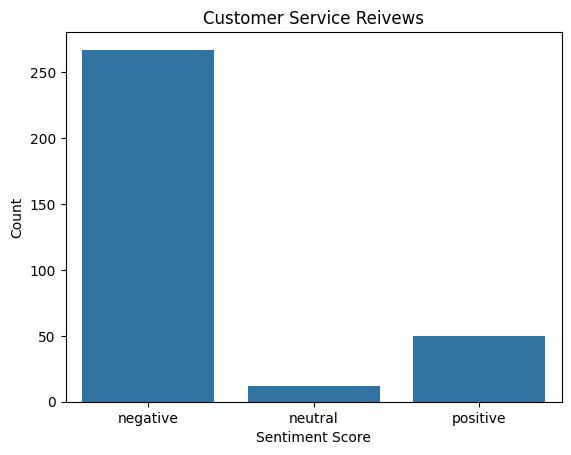

In [ ]:
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))
plt.title('Customer Service Reivews')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()


### Customer experience with the cars

In [ ]:
query = "Customer experience with the cars?"
# generate dense vector embeddings for the query
xq = retriever.encode(query).tolist()
# query pinecone
result = index.query(vector=xq, top_k=500, include_metadata=True)

In [ ]:
# the first  2 rows
result["matches"][:2]

[{'id': '138',
  'metadata': {'Unnamed: 0': 1.0,
               'Unnamed: 0.1': 138.0,
               'label': 'negative',
               'review': 'Absolutely horrible customer service. Cars '
                         'continuously are breaking and the repair facilities '
                         'are a nightmare to deal with. All of which is really '
                         'disappointing because it is so close to being a good '
                         'car if only their customer service was even just '
                         'average.',
               'score': 0.9633868336677551},
  'score': 0.642948508,
  'values': []},
 {'id': '181',
  'metadata': {'Unnamed: 0': 12.0,
               'Unnamed: 0.1': 181.0,
               'label': 'negative',
               'review': 'Very poor  customer car ! All communication are '
                         'through an app and very difficult to speak to someone '
                         'if you have an issues . The technology is excellent '
  

In [ ]:
sentiment = count_sentiment(result)
sentiment

{'negative': 267, 'neutral': 12, 'positive': 50}

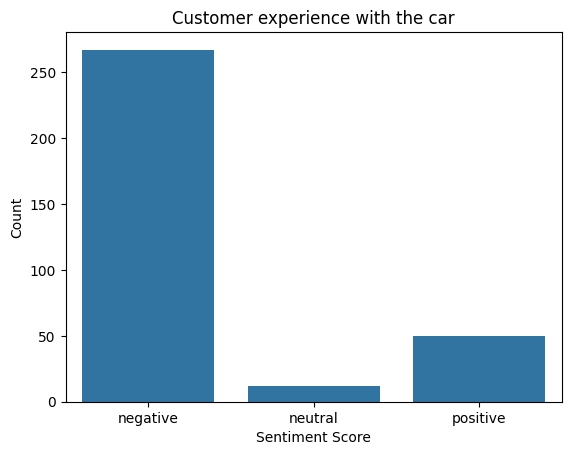

In [ ]:
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))
plt.title('Customer experience with the car')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

## Recommendation

From the bar plots above we can see that customers have posted negative reviiews regarding their experiences with Tesla staff. This identifies the area for imporvement at Tesla being cusomter services.